In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['pRT_input_data_path'] = '/home/sdregt/new_retrieval_venv/pRT_input_data'
os.environ['LD_LIBRARY_PATH'] = '/home/sdregt/new_retrieval_venv/MultiNest/lib'

from retrieval_base.rotation_profile import IntRotationProfile

In [3]:
import retrieval_base.auxiliary_functions as af
import copy

def get_Rot(prefix, m_set):
    #pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_broad_{m_set}.pkl')
    pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_{m_set}.pkl')
    return copy.copy(pRT_atm.Rot)

Rot_no_band = get_Rot('./retrieval_outputs/no_bands_K_B_ret_4/test_', m_set='K2166_A')
Rot_eq_band = get_Rot('./retrieval_outputs/eq_band_K_B_ret_1/test_', m_set='K2166_A')


ERROR:   Could not load MultiNest library "libmultinest.so"
ERROR:   You have to build it first,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: https://johannesbuchner.github.io/PyMultiNest/install.html


ERROR:   Could not load MultiNest library: libmultinest.so
ERROR:   You have to build MultiNest,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: https://johannesbuchner.github.io/PyMultiNest/install.html

problem: libmultinest.so: cannot open shared object file: No such file or directory


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [2]:
def orthographic_to_xy(lat, lon, lat_0, lon_0, R=1):

    x = R * np.cos(lat) * np.sin(lon-lon_0)
    y = R * (np.cos(lat_0)*np.sin(lat) - np.sin(lat_0)*np.cos(lat)*np.cos(lon-lon_0))

    c = np.arccos(
        np.sin(lat_0)*np.sin(lat) + np.cos(lat_0)*np.cos(lat)*np.cos(lon-lon_0)
    )

    mask = (c > -np.pi/2) & (c < np.pi/2)
    x[~mask] = np.nan
    y[~mask] = np.nan
    return x, y, c

def plot_grid(ax, lat_grid=np.arange(-90,90+1e-6,30), lon_grid=np.arange(0,360,30), inclination=26, lon_0=0, **kwargs):

    lat = np.deg2rad(np.linspace(-90,90,100))
    lon = np.deg2rad(np.linspace(0,360,100))

    inclination = np.deg2rad(inclination)
    lon_0 = np.deg2rad(lon_0)

    for lat_i in np.deg2rad(lat_grid):

        # Orthographic projection
        x, y, c = orthographic_to_xy(lat_i, lon, inclination, lon_0)

        # Convert to polar coordinates
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)

        ax.plot(phi, r, **kwargs)

    for lon_i in np.deg2rad(lon_grid):
        
        # Orthographic projection
        x, y, c = orthographic_to_xy(lat, lon_i, inclination, lon_0)

        # Convert to polar coordinates
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)

        ax.plot(phi, r, **kwargs)

def plot_map(ax, attr, Rot, cax=None, **kwargs):

    z = getattr(Rot, attr)

    for i, r_i in enumerate(Rot.unique_r):
        th_i = Rot.theta_grid[Rot.r_grid==r_i]
        z_i  = z[Rot.r_grid==r_i]
        r_i  = np.array([r_i])

        th_i = np.concatenate((th_i-th_i.min(), [2*np.pi]))

        r_i = np.array([
            np.sin(Rot.unique_c[i] - (np.pi/2)/Rot.n_c/2), 
            np.sin(Rot.unique_c[i] + (np.pi/2)/Rot.n_c/2)*2, 
            ])

        zz_shape = (len(r_i)-1,len(th_i)-1)

        tt, rr = np.meshgrid(th_i, r_i)
        zz = z_i.reshape(zz_shape)

        #ax.plot(0, Rot.unique_r[i], 'k.')
        cntr = ax.pcolormesh(np.pi/2-tt, rr, zz, shading='auto', **kwargs)

    if cax is not None:
        import matplotlib as mpl

        norm = mpl.colors.Normalize(vmin=kwargs.get('vmin'), vmax=kwargs.get('vmax'))
        plt.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=kwargs.get('cmap')), 
            ax=ax, cax=cax, orientation='vertical'
            )

In [3]:
Rot = IntRotationProfile(inc=0, lon_0=0, n_c=15, n_theta=150)
Rot_fine = IntRotationProfile(inc=0, lon_0=0, n_c=15, n_theta=150)

In [4]:
import matplotlib as mpl
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['w','maroon','w'])    

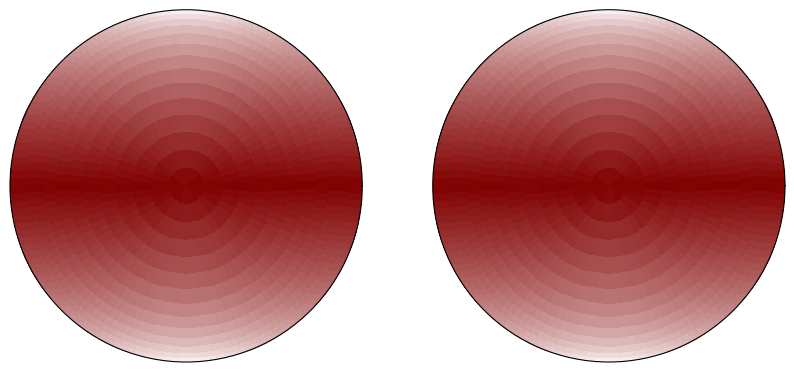

In [5]:
Rot.get_coords(sampling_factor=1)
Rot_fine.get_coords(sampling_factor=1)

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(nrows=1, ncols=2)

ax  = np.array([
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    ])

plot_map(ax[0], 'lat_grid', Rot, cmap=cmap, vmin=Rot.lat_grid.min(), vmax=Rot.lat_grid.max())
plot_map(ax[1], 'lat_grid', Rot_fine, cmap=cmap, vmin=Rot_fine.lat_grid.min(), vmax=Rot_fine.lat_grid.max())

for i, ax_i in enumerate(ax.flatten()):
    ax_i.grid(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.set_ylim(0,1)
plt.show()

In [6]:
Rot.f_grid = np.ones_like(Rot.r_grid)

lat_band = np.deg2rad(30)
for i, (lat_i, c_i, theta_i, r_i) in enumerate(zip(Rot.lat_grid, Rot.c_grid, Rot.theta_grid, Rot.r_grid)):

    mask_c = (Rot_fine.c_grid > c_i-Rot.dc/2) & (Rot_fine.c_grid < c_i+Rot.dc/2)
        
    dtheta = 2*np.pi / int(Rot.n_theta*r_i)
    mask_theta = (Rot_fine.theta_grid > theta_i-dtheta/2) & (Rot_fine.theta_grid < theta_i+dtheta/2)

    mask_in_segment = mask_c & mask_theta
    mask_above_band = np.abs(Rot_fine.lat_grid) > lat_band

    if mask_above_band[mask_in_segment].all():
        Rot.f_grid[i] = 1
    else:
        Rot.f_grid[i] = (mask_in_segment & mask_above_band).sum()

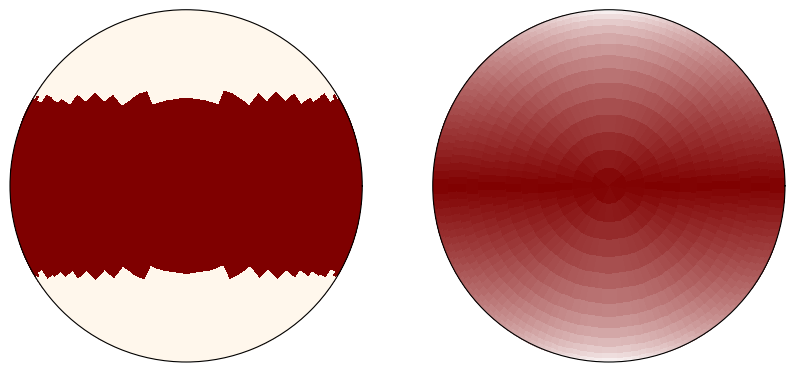

In [7]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(nrows=1, ncols=2)

ax  = np.array([
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    ])

plot_map(ax[0], 'f_grid', Rot, cmap='OrRd_r', vmin=Rot.f_grid.min(), vmax=Rot.f_grid.max())
plot_map(ax[1], 'lat_grid', Rot_fine, cmap=cmap, vmin=Rot_fine.lat_grid.min(), vmax=Rot_fine.lat_grid.max())

for i, ax_i in enumerate(ax.flatten()):
    ax_i.grid(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.set_ylim(0,1)
plt.show()

In [34]:
len(Rot.theta_grid)

1425

In [35]:
len(Rot_fine.theta_grid)

5715